###  第17組 final project
### 利用機器學習模型建構比特幣的買賣策略
---
import package

In [1]:
import pandas as pd
import numpy as np
import glob
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import seaborn as sns
import datetime as datetime
import time
import random
import os
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import talib
from talib import abstract
import itertools
from itertools import cycle

#### data preprocessing & label - triple_barrier method
---

In [2]:
def triple_barrier(df, price, ub, lb, max_period):
    def end_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    r = np.array(range(max_period))
    def end_time(s):
        return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]
    p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
    t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
    t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                   for i, k in enumerate(t)], index=t.index).dropna()
    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = int(1) #買
    signal.loc[p < lb] = int(2) #賣
    signal.iloc[-max_period+1:] = np.nan
    res = pd.DataFrame({'triple_barrier_signal':signal})
    return res

In [3]:
df = pd.read_csv('./data/BTC_day.csv', index_col=0)
df = df.iloc[365:,:] #from 2019/1/1
df.Date = df.Date.str.replace('04:00:00', '') #filter the redundancy information
df.reset_index(drop=True, inplace = True) #reindex
close_df = df.iloc[:,3]
close_df = pd.to_numeric(close_df, downcast='float')
triple_label = triple_barrier(df, close_df, 1.12, 0.96, 14) #upper:12%, lower:4%
triple_label = triple_label.iloc[:1072,:]
triple_label.to_csv('./data/BTC_day_triple_barrier.csv', encoding='utf-8-sig', index=False) #deal with the encoding issue which utf-8 is invalidation
df['label']=triple_label

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


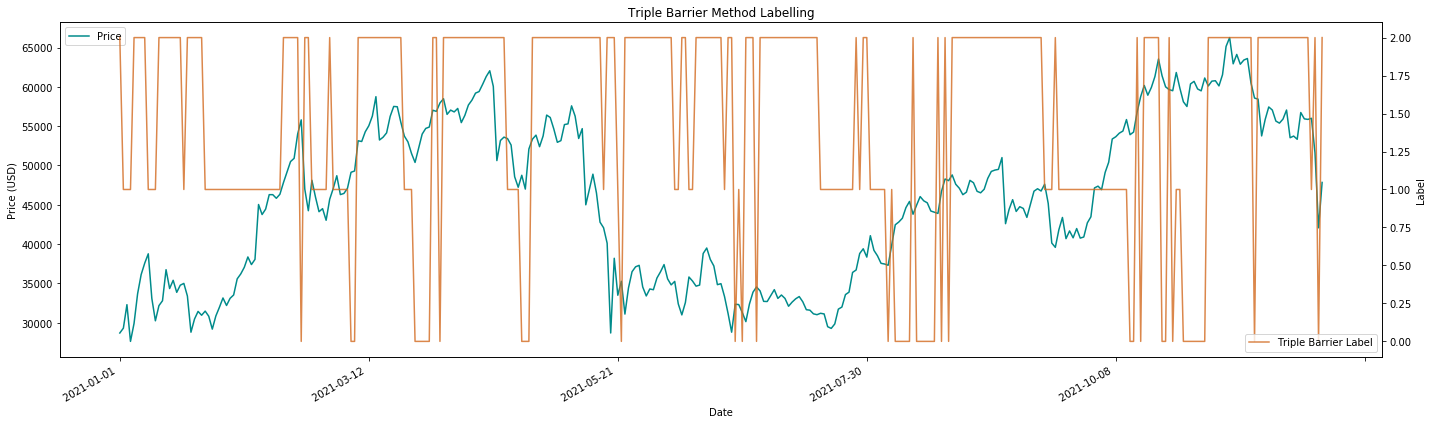

In [4]:
#plot the labeling result from 2021
df = pd.read_csv('./data/BTC_day.csv', index_col=0)
df = df.iloc[1096:1437,:] #from 2021/1/1  - 2021/12/7
df.Date = df.Date.str.replace('04:00:00', '') #filter the redundancy information
df.reset_index(drop=True, inplace = True) #reindex
close_df = df.iloc[:,3]
close_df = pd.to_numeric(close_df, downcast='float')
res = pd.read_csv('./data/BTC_day_triple_barrier.csv')
res = res.iloc[733:,:]
res.reset_index(drop=True, inplace = True)
rows, columns = df.shape
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 6)
plt.xlabel('Date')
ax2 = ax1.twinx()
signal_df = pd.DataFrame()
signal_df['Date'] = df.Date
signal_df['Close'] = close_df
signal_df['Label'] = res.triple_barrier_signal
signal_df = signal_df.dropna()
# price
ax1.set_ylabel('Price (USD)', color='black')
ax1.plot(signal_df.Date, signal_df.Close, color='darkcyan', label="Price") #close price color
ax1.legend(loc="upper left")
ax1.tick_params(axis='y', labelcolor='black')
# label
ax2.set_ylabel('Label', color='black')
ax2.plot(signal_df.Date, signal_df.Label, color='chocolate', label="Triple Barrier Label", linestyle='-', alpha=0.8) #label color
ax2.legend(loc="lower right")
ax2.tick_params(axis='y', labelcolor='black')
fig.autofmt_xdate()
tick_spacing = 70 #reduce the tick at x-axis
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing)) #invible the tick labels and mark indexex
plt.title('Triple Barrier Method Labelling')
plt.xticks(rotation=45, ha='right')   # rotate the content of xlabel and align
plt.tight_layout()
plt.show()

#### Feature engineering
---

In [5]:
def open_file(path,day = True):
    temp = []
    with open(path,newline = '',encoding= 'utf8') as csvfile:
        temp_data = csv.reader(csvfile)
        for rows in temp_data:
            temp.append(rows)
    a = pd.DataFrame(temp,columns = temp[0]).drop([0])
    if day == True:
        a['Open'] = pd.to_numeric(a['Open'])
        a['Close'] = pd.to_numeric(a['Close'])
        a['High'] = pd.to_numeric(a['High'])
        a['Low'] = pd.to_numeric(a['Low'])
        a['Volume'] = pd.to_numeric(a['Volume'])
    return a

In [6]:
path = './data/BTC_day.csv'
BTC_day = open_file(path)
path = './data/BTC_FR.csv'
BTC_FR = open_file(path,False)
BTC_FR['Funding Rate'] = pd.to_numeric(BTC_FR['Funding Rate'])

In [7]:
def bios(Volume,period):
    MV = np.convolve(Volume,np.ones(period),'valid')/period
    bios = list(np.zeros(period-1))
    index = 0
    for i in range(period-1,len(Volume)):
        bios.append((Volume[i]-MV[index])/MV[index])
        index+=1
    return bios

In [8]:
BTC_feature = pd.DataFrame()
Open = BTC_day['Open'].values
Close = BTC_day['Close'].values
High = BTC_day['High'].values
Low = BTC_day['Low'].values
Volume = BTC_day['Volume'].values
K_line = list(zip(Open,Close,High,Low))
Upper = []
Lower = []
for i in range(len(K_line)):
    K_line[i] =  sorted(K_line[i])
    Upper.append((K_line[i][3]-K_line[i][2])*100/Close[i])
    Lower.append((K_line[i][1]-K_line[i][0])*100/Close[i])

BTC_feature['RSI_14'] = talib.RSI(Close,14)
BTC_feature['MACD_DIF'],BTC_feature['MACD_signal'],BTC_feature['MACD_hist'] = talib.MACD(Close,fastperiod=12,slowperiod=26,signalperiod=9)
BTC_feature['k'],BTC_feature['d'] = abstract.STOCH(High,Low,Close,fastk_period=9, slowk_period=3,slowd_period=3)
BTC_feature['Upper%'] = Upper
BTC_feature['Lower%'] = Lower
BTC_feature['bios_MA'] = bios(Close,9)
BTC_feature['bios_Volume'] = bios(Volume,9)

In [9]:
BTC_day_FR = []
for i in range(617):
    BTC_day_FR.append(0)
BTC_day_FR.append(BTC_FR['Funding Rate'].values[0])
for i in range(len(BTC_day)-618):
    BTC_day_FR.append((BTC_FR['Funding Rate'].values[3*i+1]+BTC_FR['Funding Rate'].values[3*i+2]+BTC_FR['Funding Rate'].values[3*i+3]))
BTC_feature['FR'] = BTC_day_FR

In [10]:
BTC_feature = BTC_feature.iloc[365:,:]
BTC_day = BTC_day.iloc[365:,:]
BTC_day.to_csv("./data/BTC_day_2019.csv",index = False)
BTC_feature.to_csv("./data/BTC_day_FR_feature.csv",index = False)
BTC_feature

,RSI_14,MACD_DIF,MACD_signal,MACD_hist,k,d,Upper%,Lower%,bios_MA,bios_Volume,FR
365,49.333479,-54.806366,-94.167818,39.361452,27.905797,29.195771,1.174577,1.234373,0.011113,-0.349792,0.00
366,51.151066,-41.647644,-83.663783,42.016139,42.605640,31.788880,1.039323,0.837089,0.027103,0.045772,0.00
367,49.255244,-36.863146,-74.303656,37.440510,56.029787,42.180408,0.183588,1.094154,0.008265,-0.094524,0.00
368,50.435764,-29.114344,-65.265793,36.151450,67.622115,55.419181,0.405579,1.676203,0.017093,-0.436532,0.00
369,49.221824,-26.235888,-57.459812,31.223925,61.075671,61.575858,0.476135,1.065247,-0.000463,-0.469108,0.00
...,...,...,...,...,...,...,...,...,...,...,...
1445,35.630791,-2678.164419,-2667.692055,-10.472363,43.553312,41.321335,1.313735,0.715051,-0.014633,-0.238009,0.03
1446,32.571333,-2729.208395,-2679.995323,-49.213072,34.902027,38.777041,0.894646,1.831548,-0.037722,0.110072,0.03
1447,38.158147,-2623.720817,-2668.740422,45.019605,32.269991,36.908443,0.492062,0.444414,-0.006419,-0.515503,0.02
1448,35.845089,-2593.890368,-2653.770411,59.880043,27.288887,31.486968,1.199403,0.972145,-0.024338,-0.344771,0.03


#### XGBoost model
---

In [11]:
btcday = pd.read_csv('./data/BTC_day_FR_feature.csv')
btcday_Label = pd.read_csv('./data/BTC_day_triple_barrier.csv')
btcday_Label = btcday_Label['triple_barrier_signal']
btcday['Label'] = btcday_Label
btcday = btcday.dropna()
btcday = shuffle(btcday, random_state=0)
btcday_Label = btcday['Label']
btcday = btcday.drop(['Label'], axis=1)#

In [12]:

xgboost = XGBClassifier(n_estimators=100, learning_rate= 0.1, max_depth=13, objective='multi:softmax', num_class=3, gamma=0, min_child_weight=1, seed=1000, subsample=0.8)
btcday_predicted = cross_val_predict(xgboost, btcday, btcday_Label, cv=3)#, fit_params={'sample_weight': compute_sample_weight("balanced", btcday_Label)}
print()
print('BTC Day Triple Barrier Label')
print()
print(classification_report(btcday_Label, btcday_predicted))
print('Accuracy = ',end='')
print(accuracy_score(btcday_Label, btcday_predicted))


BTC Day Triple Barrier Label

              precision    recall  f1-score   support

         0.0       0.58      0.46      0.51       254
         1.0       0.62      0.55      0.58       308
         2.0       0.67      0.78      0.72       510

    accuracy                           0.64      1072
   macro avg       0.62      0.60      0.61      1072
weighted avg       0.63      0.64      0.63      1072

Accuracy = 0.6408582089552238


In [6]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

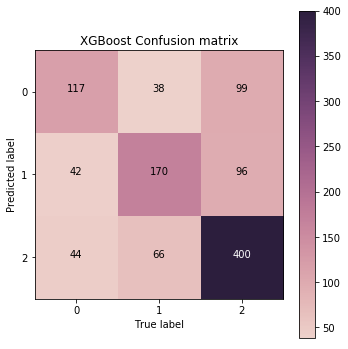

In [14]:
#Print the output cunfusion matrix and accuracy
target_names = ['0', '1', '2']


cm = confusion_matrix(y_true = btcday_Label, y_pred = btcday_predicted)
plot_confusion_matrix(cm, classes = ['0', '1', '2'], title = 'XGBoost Confusion matrix')

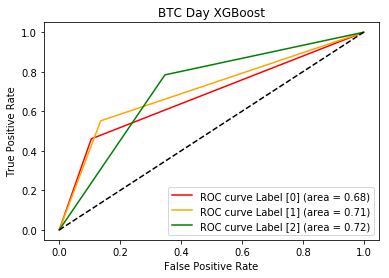

In [15]:
btcday_Label_bi = label_binarize(btcday_Label, classes=[0,1,2])
btcday_predicted_bi = label_binarize(btcday_predicted, classes=[0,1,2])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(btcday_Label_bi[:, i], btcday_predicted_bi[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot(fpr[0], tpr[0], color='red', label='ROC curve Label [0] (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='orange', label='ROC curve Label [1] (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='green', label='ROC curve Label [2] (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BTC Day XGBoost')
plt.legend()
plt.show()

In [16]:
triple_day_XGBoost = pd.DataFrame();

triple_day_XGBoost['Triple'] = btcday_Label
triple_day_XGBoost['Predict'] = btcday_predicted
triple_day_XGBoost = triple_day_XGBoost.sort_index()
triple_day_XGBoost.to_csv('./data/XGBoost_output.csv',index=0)

#### MLP model
---

In [314]:
#Data preprocessing
import pandas as pd
data_day = pd.read_csv('./data/BTC_day_FR_feature.csv')
triple_day = pd.read_csv('./data/BTC_day_triple_barrier.csv')
data_day['True'] = triple_day['triple_barrier_signal']
data_day = data_day.dropna()
triple_day = data_day['True']
data_day = data_day.drop(['True'], axis = 1)
input_dimen = data_day.shape[1]

In [315]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection  import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle

In [316]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, concatenate
from tensorflow.keras.optimizers import SGD

In [317]:
#MLP model
model = Sequential()
model.add(Dense(units = 512, input_dim = input_dimen, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.3))

model.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.3))

model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.3))

model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.3))

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
#model.add(Dropout(rate = 0.3))

model.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'softmax'))

opt = SGD(lr = 0.1, momentum = 0, decay = 0)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# Get the model and save the best model
best_model_dir = r'./data/model_MLP.h5'
save_best_model = ModelCheckpoint(best_model_dir, monitor = 'val_loss', save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)

model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_460 (Dense)            (None, 512)               6144      
_________________________________________________________________
batch_normalization_395 (Bat (None, 512)               2048      
_________________________________________________________________
dropout_350 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_461 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_396 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_351 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_462 (Dense)            (None, 128)             

C:\Users\admin\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [318]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [319]:
#Run shuffle K fold validation on MLP model
def model_kfold(features, label, k, batch, epoch, threshold) : 
    kfold = KFold(n_splits = k, shuffle = False)
    fold_no = 1
    
    #data preprocessing
    test_label = []
    predict_label = []
    index_list = []
    index = features.index
    features, label, index = shuffle(features, label, index, random_state = 42)
    label = pd.get_dummies(label, prefix = 'Label')
    index = np.array(index)
    label = np.array(label)
    features = np.array(features)
    
    for train, test in kfold.split(features, label, index):

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        
        #model fitting
        train_history = model.fit(features[train], label[train], validation_data = (features[test], label[test]), 
                                  batch_size = batch,epochs = epoch,verbose = 1, callbacks = [early_stopping, save_best_model])
        
        #If threshold = 0, MLP pick the largest probability of the label as its prediction
        #If threshold > 0, MLP only predict the label with probabilty >= 0.5, otherwise predict 0 (hold)
        if threshold > 0:
            predict = model.predict(features[test])
            for i in range(len(predict)):
                max_val = predict[i].max()
                for j in range(len(predict[i])):
                    if predict[i][j] < max_val:
                        predict[i][j] = 0
                    
            #predict = (best_model.predict(features[test]) > threshold).astype("int32")
            predict = (predict > threshold).astype("int32")
            
            for i in range(len(predict)):
                if predict[i].max() != 1:
                    predict[i][0] = 1
        else:
            predict = model.predict(features[test])
            b = np.zeros_like(predict)
            b[np.arange(len(predict)), predict.argmax(1)] = 1
            predict = b
        
        #create output array
        if len(test_label) == 0:
            test_label = label[test]
            predict_label = predict
        else:
            test_label = np.concatenate((test_label, label[test]), axis = 0)
            predict_label = np.concatenate((predict_label, predict), axis = 0)
            
        # Increase fold number
        fold_no = fold_no + 1
    
    
    return predict_label, test_label

In [320]:
# Funciton for visualizing confusion_matrix
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

In [321]:
#Generate output dataframe
def predict_output(predict, true):
    true = triple_day
    model = load_model(r'./data/model_MLP.h5')
    predict = model.predict(data_day)
    predict = [int(np.argmax(y, axis = None, out = None)) for y in predict]
    predict = pd.DataFrame(predict, columns = ['Predict'])
    true = pd.DataFrame(true, columns = ['True'])
    true['Predict'] = predict['Predict']
    true.to_csv('./data/MLP_output.csv', index = None)

In [322]:
#Training and save output as CSV file
#The input parameters of model_kfold are data, label, k, batch, epoch, threshold
predict_day_triple, true_day_triple = model_kfold(data_day, triple_day, 10, 50, 100, 0)
predict_output(predict_day_triple, true_day_triple)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
20/20 [==============================] - 4s 41ms/step - loss: 1.0813 - accuracy: 0.3963 - val_loss: 1.0830 - val_accuracy: 0.5093
Epoch 2/100
20/20 [==============================] - 0s 17ms/step - loss: 1.0639 - accuracy: 0.3952 - val_loss: 1.0761 - val_accuracy: 0.5093
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 1.0397 - accuracy: 0.4481 - val_loss: 1.0689 - val_accuracy: 0.5093
Epoch 4/100
20/20 [==============================] - 0s 16ms/step - loss: 1.0341 - accuracy: 0.4388 - val_loss: 1.0610 - val_accuracy: 0.5093
Epoch 5/100
20/20 [==============================] - 0s 15ms/step - loss: 1.0241 - accuracy: 0.4710 - val_loss: 1.0508 - val_accuracy: 0.5093
Epoch 6/100
20/20 [==============================] - 0s 17ms/step - loss: 1.0116 - accuracy: 0.5041 - val_loss: 1.0429 - val_accuracy: 0.5093
Epoch 7/100
20/20 [==============================] 

Epoch 58/100
20/20 [==============================] - 0s 18ms/step - loss: 0.9283 - accuracy: 0.5664 - val_loss: 0.8956 - val_accuracy: 0.5648
Epoch 59/100
20/20 [==============================] - 0s 19ms/step - loss: 0.9357 - accuracy: 0.5622 - val_loss: 0.9054 - val_accuracy: 0.5741
Epoch 60/100
20/20 [==============================] - 0s 21ms/step - loss: 0.9272 - accuracy: 0.5602 - val_loss: 0.9093 - val_accuracy: 0.5648
Epoch 61/100
20/20 [==============================] - 0s 18ms/step - loss: 0.9356 - accuracy: 0.5591 - val_loss: 0.8950 - val_accuracy: 0.6019
Epoch 62/100
20/20 [==============================] - 0s 18ms/step - loss: 0.9192 - accuracy: 0.5654 - val_loss: 0.8941 - val_accuracy: 0.5741
Epoch 63/100
20/20 [==============================] - 0s 18ms/step - loss: 0.9119 - accuracy: 0.5820 - val_loss: 0.9012 - val_accuracy: 0.6111
Epoch 64/100
20/20 [==============================] - 0s 18ms/step - loss: 0.9001 - accuracy: 0.5882 - val_loss: 0.9055 - val_accuracy: 0.5926

Epoch 9/100
20/20 [==============================] - 0s 17ms/step - loss: 0.8819 - accuracy: 0.6073 - val_loss: 0.9858 - val_accuracy: 0.5421
Epoch 10/100
20/20 [==============================] - 0s 17ms/step - loss: 0.9006 - accuracy: 0.5772 - val_loss: 0.9984 - val_accuracy: 0.5047
Epoch 11/100
20/20 [==============================] - 0s 17ms/step - loss: 0.8822 - accuracy: 0.5927 - val_loss: 1.0037 - val_accuracy: 0.4953
Epoch 12/100
20/20 [==============================] - 0s 16ms/step - loss: 0.8807 - accuracy: 0.5990 - val_loss: 1.0225 - val_accuracy: 0.5140
Epoch 13/100
20/20 [==============================] - 0s 18ms/step - loss: 0.8792 - accuracy: 0.5938 - val_loss: 1.0044 - val_accuracy: 0.5140
Epoch 14/100
20/20 [==============================] - 0s 17ms/step - loss: 0.8880 - accuracy: 0.5907 - val_loss: 0.9861 - val_accuracy: 0.4953
Epoch 15/100
20/20 [==============================] - 0s 17ms/step - loss: 0.8787 - accuracy: 0.5990 - val_loss: 1.0016 - val_accuracy: 0.5047


Epoch 12/100
20/20 [==============================] - 0s 14ms/step - loss: 0.8950 - accuracy: 0.5845 - val_loss: 0.8358 - val_accuracy: 0.5888
Epoch 13/100
20/20 [==============================] - 0s 15ms/step - loss: 0.8827 - accuracy: 0.5917 - val_loss: 0.8227 - val_accuracy: 0.6355
Epoch 14/100
20/20 [==============================] - 0s 14ms/step - loss: 0.8787 - accuracy: 0.6104 - val_loss: 0.8433 - val_accuracy: 0.6168
Epoch 00014: early stopping
------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/100
20/20 [==============================] - 0s 15ms/step - loss: 0.8802 - accuracy: 0.5938 - val_loss: 0.8483 - val_accuracy: 0.6168
Epoch 2/100
20/20 [==============================] - 0s 13ms/step - loss: 0.8687 - accuracy: 0.5917 - val_loss: 0.8185 - val_accuracy: 0.6355
Epoch 3/100
20/20 [==============================] - 0s 14ms/step - loss: 0.8953 - accuracy: 0.5824 - val_loss: 0.8163 - val_accuracy: 0.6449
Epoch 4/100
20/20 [=

BTC Day Triple Barrier Label
              precision    recall  f1-score   support

           0       0.36      0.54      0.43       169
           1       0.49      0.57      0.52       265
           2       0.77      0.62      0.69       638

   micro avg       0.59      0.59      0.59      1072
   macro avg       0.54      0.57      0.55      1072
weighted avg       0.64      0.59      0.61      1072
 samples avg       0.59      0.59      0.59      1072

0.5932835820895522


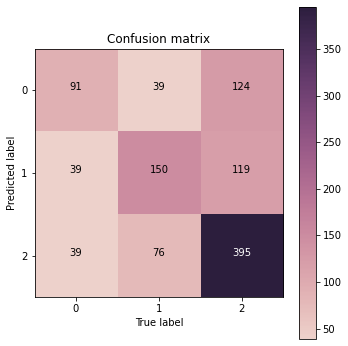

In [323]:
#Print the output cunfusion matrix and accuracy
target_names = ['0', '1', '2']
print('BTC Day Triple Barrier Label')
print(classification_report(predict_day_triple, true_day_triple, target_names = target_names))
print(accuracy_score(predict_day_triple, true_day_triple))
predict = [int(np.argmax(y, axis = None, out = None))for y in predict_day_triple]
true = [int(np.argmax(y, axis = None, out = None)) for y in true_day_triple]

In [324]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [325]:
#function to plot the roc curve
def roc(y_pred, y_test, title): 
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 3

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['red', 'blue', 'green'])
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color = color, lw = 2,
                  label = 'ROC curve of class {0} (area = {1:0.2f})'
                  ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw = 2)
    plt.xlim([0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

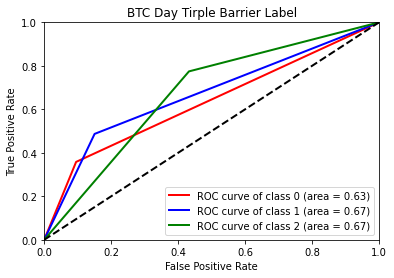

In [326]:
roc(predict_day_triple, true_day_triple, 'BTC Day Tirple Barrier Label')

#### 績效回測
---

In [8]:
def open_file(path):
    temp = []
    with open(path,newline = '',encoding= 'utf8') as csvfile:
        temp_data = csv.reader(csvfile)
        for rows in temp_data:
            for i,strings in enumerate(rows):
                rows[i] = strings.rstrip()
            temp.append(rows)
    a = pd.DataFrame(temp,columns = temp[0]).drop([0]).reset_index(drop = True)
    return a

In [9]:
### import data ###
import csv
label_tri_d_NN = open_file('./data/MLP_output.csv')
label_tri_d_XG = open_file('./data/XGBoost_output.csv')
price_d = open_file('./data/BTC_day.csv')

price_d = price_d.iloc[365:,:] #from 2019/1/1
price_d['Open'] = pd.to_numeric(price_d['Open'])
price_d['Close'] = pd.to_numeric(price_d['Close'])
price_d['High'] = pd.to_numeric(price_d['High'])
price_d['Low'] = pd.to_numeric(price_d['Low'])
price_d['Volume'] = pd.to_numeric(price_d['Volume'])

In [10]:
### BUY&HOLD ###
def buy_hold(price,label,USD_init = 10000):
    label = label[label.columns[-1]].values
    coin,USD,coin_USD,balance,bal_perc,bal_USD,drawdown = [],[],[],[],[],[],[]
    close = price['Close'].values
    coin.append(USD_init/close[0])
    USD.append(0)
    coin_USD.append(USD_init)
    balance.append(USD_init)
    bal_perc.append(0)
    bal_USD.append(0)
    drawdown.append(0)
    for d in range(1,len(label)):
        coin.append(coin[d-1])
        USD.append(0)
        coin_USD.append(coin[d]*close[d])
        balance.append(coin_USD[d]+USD[d])
        bal_perc.append((balance[d]-balance[d-1])*100/balance[d-1])
        bal_USD.append((balance[d]-USD_init)*100/USD_init)
        drawdown.append((1-balance[d]/max(balance[:d])))
    return coin,USD,coin_USD,balance,bal_perc,bal_USD,drawdown
### strategy ###
def strategy(price,label,USD_init = 10000,coin_init_ratio = 0.5,change_ratio = 0.05):
    coin,USD,coin_USD,balance,bal_perc,bal_USD,drawdown = [],[],[],[],[],[],[]
    close = price['Close'].values
    label = label[label.columns[-1]].values
    coin_USD.append(USD_init*coin_init_ratio)
    USD.append(USD_init*(1-coin_init_ratio))
    coin.append(USD_init*coin_init_ratio/close[0])
    balance.append(USD_init)
    bal_perc.append(0)
    bal_USD.append(0)
    drawdown.append(0)
    for d in range(1,len(label)):
        if label[d] == '1.0' or label[d] == '1':#買
            USD.append(USD[d-1]*(1-change_ratio*2))
            coin.append(coin[d-1]+USD[d-1]*change_ratio*2/close[d])
            coin_USD.append(coin[d]*close[d])
            balance.append(coin_USD[d]+USD[d])
            bal_perc.append((balance[d]-balance[d-1])*100/balance[d-1])
            bal_USD.append((balance[d]-USD_init)*100/USD_init)
            drawdown.append((1-balance[d]/max(balance[:d])))
        elif label[d] == '2.0' or label[d] == '2':#賣
            coin_USD.append(coin[d-1]*close[d]*(1-change_ratio))
            coin.append(coin[d-1]-coin[d-1]*close[d]*change_ratio/close[d])
            USD.append(USD[d-1]+coin[d-1]*close[d]*change_ratio)
            balance.append(coin_USD[d]+USD[d])
            bal_perc.append((balance[d]-balance[d-1])*100/balance[d-1])
            bal_USD.append((balance[d]-USD_init)*100/USD_init)
            drawdown.append((1-balance[d]/max(balance[:d])))
        else:
            coin.append(coin[d-1])
            USD.append(USD[d-1])
            coin_USD.append(coin[d]*close[d])
            balance.append(coin_USD[d]+USD[d])
            bal_perc.append((balance[d]-balance[d-1])*100/balance[d-1])
            bal_USD.append((balance[d]-USD_init)*100/USD_init)
            drawdown.append((1-balance[d]/max(balance[:d])))
    return coin,USD,coin_USD,balance,bal_perc,bal_USD,drawdown


In [11]:
### def functions ###
def sharpe_ratio(df,day = True):
    Reward = df['Balance_perc'].mean()
    risk = df['Balance_perc'].std()
    sharpe = Reward/risk
    if day == True:
        yearly= sharpe*(365)**0.5
    else:
        yearly = sharpe*(365*6)**0.5
    return sharpe,yearly
def sortino_ratio(df,day = True):
    sortino = df['Balance_perc'].mean()/df[df.Balance_perc<0]['Balance_perc'].std()
    if day == True:
        yearly = sortino*(365)**0.5
    else:
        yearly = sortino*(365*6)**0.5
    return sortino,yearly
def ROI_IRR(df,day = True):
    ROI_v = (list(df.Balance)[-1]-df.Balance[0])/df.Balance[0]
    if day == True:
        IRR  = (ROI_v+1)**(1/(len(df)/365)) -1
    else:
        IRR  = (ROI_v+1)**(1*365*6/len(df)) -1
    return ROI_v,IRR

def max_drawdown(df):
    return max(df['Drawdown'].values)

In [12]:
### day ###
coin,USD,coin_USD,balance,bal_perc,bal_USD,drawdown = buy_hold(price_d,label_tri_d_NN)
DATA = {'Coin':coin,'USD' :USD, 'Coin_USD':coin_USD, 'Balance':balance, 'Balance_perc':bal_perc,'Balance_USD':bal_USD,'Drawdown':drawdown}
bh_d = pd.DataFrame(data = DATA)
interact_day_bh = pd.concat([price_d.iloc[:len(bh_d)],bh_d,label_tri_d_NN['Predict'][:len(bh_d)]],axis = 1)



coin,USD,coin_USD,balance,bal_perc,bal_USD,drawdown = strategy(price_d,label_tri_d_NN)
DATA = {'Coin':coin,'USD' :USD, 'Coin_USD':coin_USD, 'Balance':balance, 'Balance_perc':bal_perc,'Balance_USD':bal_USD,'Drawdown':drawdown}
nn_tri = pd.DataFrame(data = DATA)
triple_day_nn = pd.concat([price_d.iloc[:len(nn_tri)],nn_tri,label_tri_d_NN['Predict'][:len(nn_tri)]],axis = 1)


coin,USD,coin_USD,balance,bal_perc,bal_USD,drawdown = strategy(price_d,label_tri_d_XG)
DATA = {'Coin':coin,'USD' :USD, 'Coin_USD':coin_USD, 'Balance':balance, 'Balance_perc':bal_perc,'Balance_USD':bal_USD,'Drawdown':drawdown}
XG_tri = pd.DataFrame(data = DATA)
triple_day_XG = pd.concat([price_d.iloc[:len(XG_tri)],XG_tri,label_tri_d_XG['Predict'][:len(XG_tri)]],axis = 1)



In [13]:
sharpe_bh_d,sharpe_bh_d_y = sharpe_ratio(bh_d) 
sortino_bh_d,sortino_bh_d_y = sortino_ratio(bh_d) 
ROI_bh_d,IRR_bh_d = ROI_IRR(bh_d) 
max_bh = max_drawdown(bh_d)


sharpe_nn_tri,sharpe_nn_tri_y = sharpe_ratio(nn_tri) 
sortino_nn_tri,sortino_nn_tri_y = sortino_ratio(nn_tri) 
ROI_nn_tri,IRR_nn_tri = ROI_IRR(nn_tri) 
max_nn_tri = max_drawdown(nn_tri)


sharpe_XG_tri,sharpe_XG_tri_y = sharpe_ratio(XG_tri) 
sortino_XG_tri,sortino_XG_tri_y = sortino_ratio(XG_tri) 
ROI_XG_tri,IRR_XG_tri = ROI_IRR(XG_tri) 
max_XG_tri = max_drawdown(XG_tri)
print('BTC_day')
print()
print(f'yearly sharpe ratio: B&H:{sharpe_bh_d_y:.4f},MLP_predict:{sharpe_nn_tri_y:.4f}, XGBoost_predict:{sharpe_XG_tri_y:.4f}')
print(f'yearly sortino ratio: B&H:{sortino_bh_d_y:.4f},MLP_predict:{sortino_nn_tri_y:.4f}, XGBoost_predict:{sortino_XG_tri_y:.4f}')
print()
print(f'ROI: B&H:{ROI_bh_d:.4f},MLP_predict:{ROI_nn_tri:.4f}, XGBoost_predict:{ROI_XG_tri:.4f}')
print(f'IRR: B&H:{IRR_bh_d:.4f},MLP_predict:{IRR_nn_tri:.4f}, XGBoost_predict:{IRR_XG_tri:.4f}')
print()
print(f'max drawdown: B&H:{max_bh:.4f},MLP_predict:{max_nn_tri:.4f}, XGBoost_predict:{max_XG_tri:.4f}')

BTC_day

yearly sharpe ratio: B&H:1.5354,MLP_predict:2.5659, XGBoost_predict:2.5744
yearly sortino ratio: B&H:2.1108,MLP_predict:3.5986, XGBoost_predict:3.7851

ROI: B&H:12.2137,MLP_predict:17.6684, XGBoost_predict:15.7710
IRR: B&H:1.4082,MLP_predict:1.7089, XGBoost_predict:1.6118

max drawdown: B&H:0.6019,MLP_predict:0.2127, XGBoost_predict:0.2019


C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


<bound method Figure.show of <Figure size 2592x1440 with 1 Axes>>

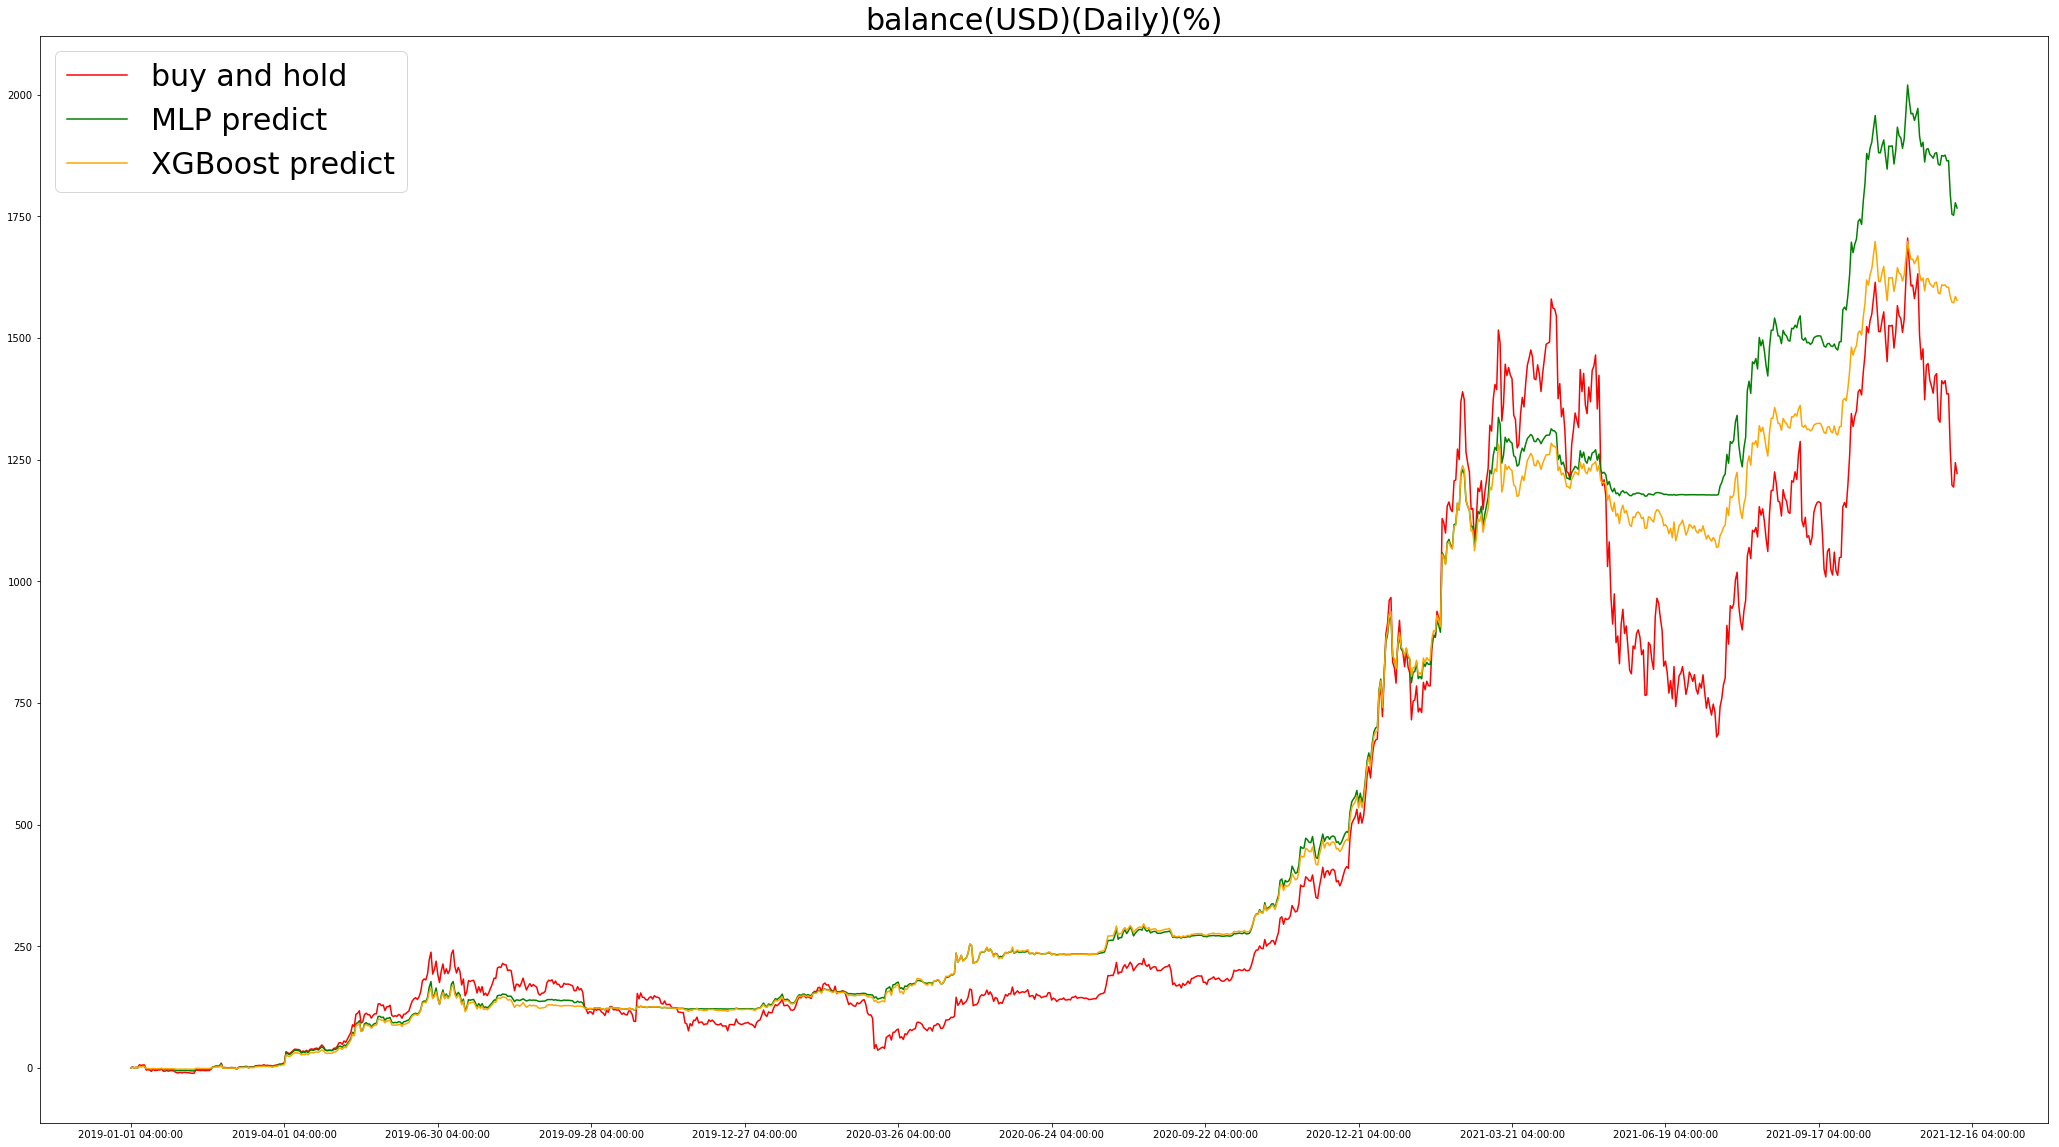

In [14]:
DATE = price_d.Date[:len(bh_d.Balance_perc)]
fig, ax3 = plt.subplots(1,1,figsize = (36,20))
ax3.plot(DATE,bh_d.Balance_USD,c = 'r',label = 'buy and hold')
#ax3.plot(DATE,nn_int.Balance_USD,c = 'b',label = 'NN_interact')
ax3.plot(DATE,nn_tri.Balance_USD,c = 'g',label = 'MLP predict')
#ax3.plot(DATE,XG_int.Balance_USD,c = 'purple',label = 'XG_interact')
ax3.plot(DATE,XG_tri.Balance_USD,c = 'orange',label = 'XGBoost predict')
ax3.set_xticks(range(0, len(price_d.Date), 90))
ax3.set_xticklabels(price_d.Date[::90])
ax3.set_title('balance(USD)(Daily)(%)',fontsize = 30)
ax3.legend(fontsize = 30)
fig.show

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


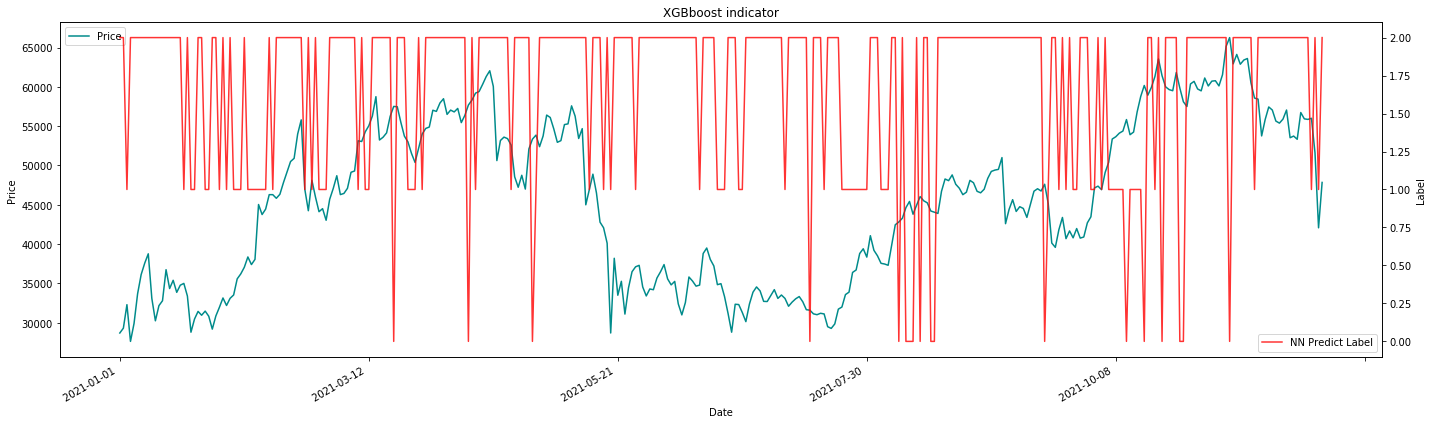

In [15]:
#plot the predict result of XGBoost from 2021
df = pd.read_csv('./data/BTC_day.csv', index_col=0)
df = df.iloc[1096:1437,:]
df.Date = df.Date.str.replace('04:00:00', '') #filter the redundancy information
df.reset_index(drop=True, inplace = True) #reindex
close_df = df.iloc[:,3]
close_df = pd.to_numeric(close_df, downcast='float')
res = pd.read_csv('./data/XGBoost_output.csv', index_col=0)
res = res.iloc[733:,:]
res.reset_index(drop=True, inplace = True)
rows, columns = df.shape
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 6)
plt.xlabel('Date')
ax2 = ax1.twinx()
signal_df = pd.DataFrame()
signal_df['Date'] = df.Date
signal_df['Close'] = close_df
signal_df['Label'] = res.Predict
signal_df = signal_df.dropna()
# price
ax1.set_ylabel('Price', color='black')
ax1.plot(signal_df.Date, signal_df.Close, color='darkcyan', label="Price")
ax1.legend(loc="upper left")
ax1.tick_params(axis='y', labelcolor='black')
# label
ax2.set_ylabel('Label', color='black')
ax2.plot(signal_df.Date, signal_df.Label, color='red', label="NN Predict Label", linestyle='-', alpha=0.8)
ax2.legend(loc="lower right")
ax2.tick_params(axis='y', labelcolor='black')
fig.autofmt_xdate()
tick_spacing = 70
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing)) #invible the tick labels and mark indexex
plt.xticks(rotation=45, ha='right')   # rotate the content of xlabel and align
plt.title('XGBboost indicator')
plt.tight_layout()
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


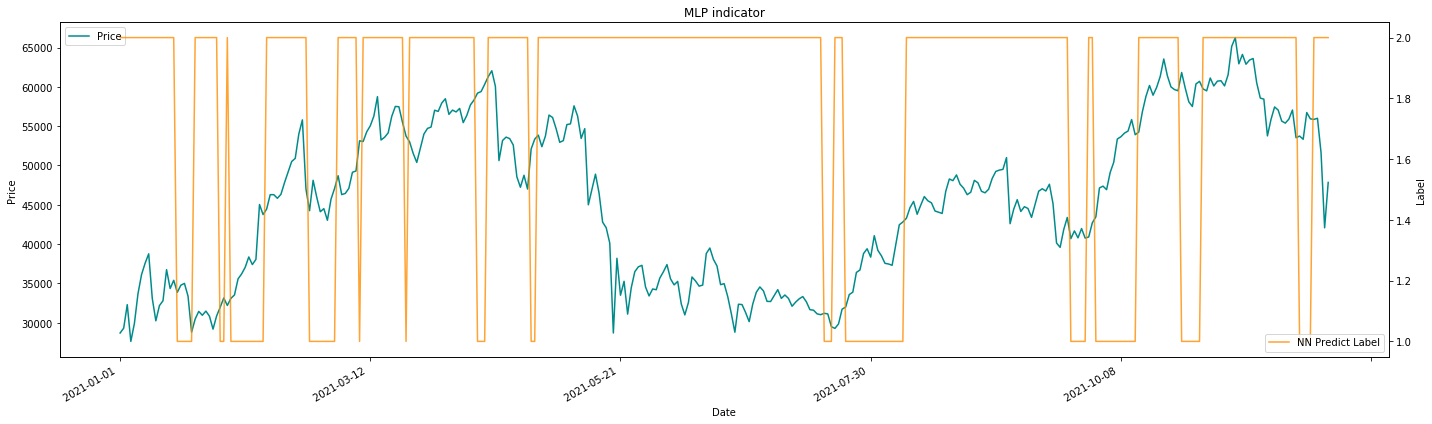

In [16]:
#plot the predict result of MLP from 2021
df = pd.read_csv('./data/BTC_day.csv', index_col=0)
df = df.iloc[1096:1437,:]
df.Date = df.Date.str.replace('04:00:00', '') #filter the redundancy information
df.reset_index(drop=True, inplace = True) #reindex
close_df = df.iloc[:,3]
close_df = pd.to_numeric(close_df, downcast='float')
res = pd.read_csv('./data/MLP_output.csv', index_col=0)
res = res.iloc[733:,:]
res.reset_index(drop=True, inplace = True)
rows, columns = df.shape
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 6)
plt.xlabel('Date')
ax2 = ax1.twinx()
signal_df = pd.DataFrame()
signal_df['Date'] = df.Date
signal_df['Close'] = close_df
signal_df['Label'] = res.Predict
signal_df = signal_df.dropna()
# price
ax1.set_ylabel('Price', color='black')
ax1.plot(signal_df.Date, signal_df.Close, color='darkcyan', label="Price")
ax1.legend(loc="upper left")
ax1.tick_params(axis='y', labelcolor='black')
# label
ax2.set_ylabel('Label', color='black')
ax2.plot(signal_df.Date, signal_df.Label, color='darkorange', label="NN Predict Label", linestyle='-', alpha=0.8)
ax2.legend(loc="lower right")
ax2.tick_params(axis='y', labelcolor='black')
fig.autofmt_xdate()
tick_spacing = 70
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing)) #invible the tick labels and mark indexex
plt.xticks(rotation=45, ha='right')   # rotate the content of xlabel and align
plt.title('MLP indicator')
plt.tight_layout()
plt.show()